In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu)

S = 512
VS = 256 # volume size
VSf = float(VS)
density_scale = 10.0

def Trilinear(tex, x, y, z):
    xi, yi, zi = tf.floor(x), tf.floor(y), tf.floor(z)
    xf, yf, zf = x-xi, y-yi, z-zi
    xi, yi, zi = tf.int(xi), tf.int(yi), tf.int(zi)
    oxf, oyf, ozf = 1.0-xf, 1.0-yf, 1.0-zf
    return tex[xi, yi, zi]*oxf*oyf*ozf + tex[xi+1, yi, zi]*xf*oyf*ozf + tex[xi, yi+1, zi]*oxf*yf*ozf + tex[xi+1, yi+1, zi]*xf*yf*ozf + tex[xi, yi, zi+1]*oxf*oyf*zf + tex[xi+1, yi, zi+1]*xf*oyf*zf + tex[xi, yi+1, zi+1]*oxf*yf*zf + tex[xi+1, yi+1, zi+1]*xf*yf*zf

vol_bbox = 1.5

def ToVolumeSpace(x, y, z):
    x = (x + vol_bbox) / (2.0 * vol_bbox) * VSf
    y = (y + vol_bbox) / (2.0 * vol_bbox) * VSf
    z = (z + vol_bbox) / (2.0 * vol_bbox) * VSf
    return x, y, z

def FromVolumeSpace(x, y, z):
    x = (x / VSf) * (2.0 * vol_bbox) - vol_bbox
    y = (y / VSf) * (2.0 * vol_bbox) - vol_bbox
    z = (z / VSf) * (2.0 * vol_bbox) - vol_bbox
    return x, y, z

def SampleVolume(volume, x, y, z):
    x, y, z = ToVolumeSpace(x, y, z)

    #check if we are outside the volume
    check_inside = tf.float((x>0.0) & (x<VS-1.0) & (y>0.0) & (y<VS-1.0) & (z>0.0) & (z<VS-1.0))
    tf.if_cond(check_inside < 0.5, lambda: tf.continue_loop())

    return Trilinear(volume, x, y, z) * check_inside * density_scale

def MarchRay(volume, shape, camx, camy, camz, dirx, diry, dirz, dx=0.05, steps=64):
    td = tf.zeros(shape, tf.float32)
    density = tf.zeros(shape, tf.float32)
    def loop_body(k):
        px = camx + dirx * td
        py = camy + diry * td
        pz = camz + dirz * td
        td.set(td + dx)
        rho = SampleVolume(volume, px, py, pz)
        density.set(density + rho*dx)

        tf.if_cond(density > 5.0, lambda: tf.break_loop())

    tf.loop(loop_body, 0, steps, 1)
    return density

def MarchColor(dens, colx, coly, colz, camx, camy, camz, dirx, diry, dirz, dx):
    td = tf.zeros([S, S], tf.float32)
    cx = tf.zeros([S, S], tf.float32)
    cy = tf.zeros([S, S], tf.float32)
    cz = tf.zeros([S, S], tf.float32)
    density = tf.zeros([S, S], tf.float32)
    def loop_body(k):
        px = camx + dirx * td
        py = camy + diry * td
        pz = camz + dirz * td
        td.set(td + dx)

        rho = SampleVolume(dens, px, py, pz)
        crhox = SampleVolume(colx, px, py, pz)
        crhoy = SampleVolume(coly, px, py, pz)
        crhoz = SampleVolume(colz, px, py, pz)

        opacity = tf.exp(-density) * rho * dx
        cx.set(cx + crhox * opacity)
        cy.set(cy + crhoy * opacity)
        cz.set(cz + crhoz * opacity)
        density.set(density + rho*dx)

        tf.if_cond(density > 5.0, lambda: tf.break_loop())

    tf.loop(loop_body, 0, 256, 1)

    return cx, cy, cz

light_dir_x = -0.577
light_dir_y = -0.577
light_dir_z = -0.577

def spherical_to_cartesian(r, theta, phi):
    # Convert spherical to Cartesian coordinates
    x = r * tf.sin(phi) * tf.cos(theta)
    y = r * tf.sin(phi) * tf.sin(theta)
    z = r * tf.cos(phi)
    return x, y, z

def cross(a, b):
    return a[1] * b[2] - a[2] * b[1], a[2] * b[0] - a[0] * b[2], a[0] * b[1] - a[1] * b[0]

def dot(a, b):
    return a[0] * b[0] + a[1] * b[1] + a[2] * b[2]

def normalize(a):
    mag = tf.sqrt(dot(a, a))
    return a[0] / mag, a[1] / mag, a[2] / mag

def mul(a, b):
    return a[0] * b, a[1] * b, a[2] * b

def add(a, b):
    return a[0] + b[0], a[1] + b[1], a[2] + b[2]

def camera_axes(r, phi, theta):
    # Camera position
    cam = spherical_to_cartesian(r, theta+1e-4, phi+1e-4)
    
    # Forward vector (normalized vector from camera position to origin)
    forward = mul(normalize(cam), -1.0)
    
    # Assuming Z is up
    world_up = 0.0, 0.0, 1.0
    
    # Right vector (cross product of world up and forward vector)
    right = cross(world_up, forward)
    right = normalize(right)
    
    # Recalculate the up vector to ensure orthogonality
    up = cross(forward, right)
    up = normalize(up)
    
    return cam, up, forward, right

def get_camera(u, v, dist, phi, theta):
    cam, up, forward, right = camera_axes(dist, phi, theta)

    dirx = forward[0] + u * right[0] + v * up[0]
    diry = forward[1] + u * right[1] + v * up[1]
    dirz = forward[2] + u * right[2] + v * up[2]

    # normalize direction
    direction = normalize((dirx, diry, dirz))

    return cam[0], cam[1], cam[2], direction[0], direction[1], direction[2]

def volume_ray_marcher():
    volume = tf.input([VS, VS, VS], tf.float32)

    # compute volume shadows
    i,j,k = volume.indices
    x, y, z = FromVolumeSpace(tf.float(i), tf.float(j), tf.float(k))
    shadow = tf.exp(-MarchRay(volume, volume.shape, x, y, z, light_dir_x, light_dir_y, light_dir_z, 0.05, 16))

    canvas = tf.zeros([S, S, 3], tf.float32)
    N, M, _ = canvas.shape
    i, j = tf.indices([N, M])
    u, v = tf.float(i), tf.float(j)
    u = (u - 0.5 * tf.float(N)) / tf.float(N)
    v = (v - 0.5 * tf.float(M)) / tf.float(M)
    
    camx, camy, camz, dirx, diry, dirz = get_camera(u, v, 3.0, 2.5, 1.0)
    
    cx, cy, cz = MarchColor(volume, shadow, shadow, shadow, camx, camy, camz, dirx, diry, dirz, 0.025)

    canvas[i, j, 0] = cx
    canvas[i, j, 1] = cy
    canvas[i, j, 2] = cz
    
    return [canvas]

raymarch = tf.compile(volume_ray_marcher)


TensorFrost module loaded!
volume_ray_marcher:
  Kernel count: 4
  Intermediate buffers: 4
  Lines of generated code: 1284



mandelbulb_volume:
  Kernel count: 1
  Intermediate buffers: 0
  Lines of generated code: 362



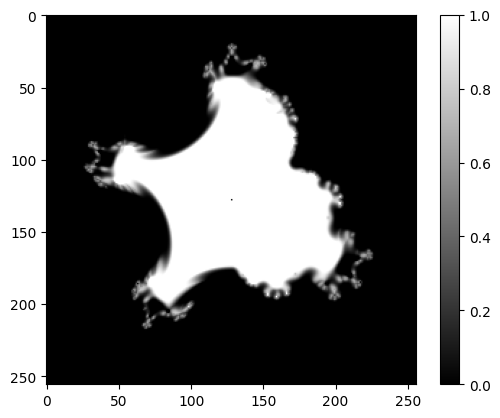

In [2]:


m_pow = 4.0
max_depth = 6.0
min_dist = 0.005

def mandelbulb(px, py, pz):
    wx, wy, wz = tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32)
    wx.set(px), wy.set(py), wz.set(pz)
    m = wx*wx + wy*wy + wz*wz
    dz = tf.zeros(px.shape, tf.float32)
    dz.set(1.0)
    #orbit trap
    cx, cy, cz = tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32), tf.zeros(px.shape, tf.float32)
    cx.set(tf.abs(wx)), cy.set(tf.abs(wy)), cz.set(tf.abs(wz))
    def loop_body(i):
        dz.set(m_pow * m ** (0.5*(m_pow - 1.0)) * dz + 1.0)
        r = tf.sqrt(wx*wx + wy*wy + wz*wz)
        b = m_pow * tf.acos(wy/r)
        a = m_pow * tf.atan2(wx, wz)
        c = r ** m_pow
        wx.set(px + c * tf.sin(b) * tf.sin(a))
        wy.set(py + c * tf.cos(b))
        wz.set(pz + c * tf.sin(b) * tf.cos(a))
        cx.set(tf.min(cx, tf.abs(wx)))
        cy.set(tf.min(cy, tf.abs(wy)))
        cz.set(tf.min(cz, tf.abs(wz)))
        m.set(wx*wx + wy*wy + wz*wz)
        tf.if_cond(m > 256.0, lambda: tf.break_loop())

    tf.loop(loop_body, 0, 4, 1)
    sdf = 0.25 * tf.log(m) * tf.sqrt(m) / dz
    return sdf, cx, cy, cz

def smoothstep(x, edge0, edge1):
    t = tf.clamp((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    return t * t * (3.0 - 2.0 * t)

def mandelbulb_volume():
    i, j, k = tf.indices([VS, VS, VS])
    x, y, z = FromVolumeSpace(tf.float(i), tf.float(j), tf.float(k))
    sdf, cx, cy, cz = mandelbulb(x, y, z)
    density = smoothstep(sdf, 0.01, -0.01)
    return [density]

mandelbulb_volume = tf.compile(mandelbulb_volume)

# Create volume
volume, = mandelbulb_volume()
volume_np = volume.numpy

# Plot slice
plt.imshow(volume_np[VS//2], cmap='gray')
plt.colorbar()
plt.show()

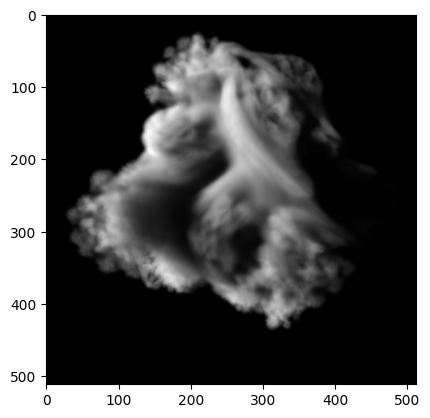

In [3]:
img, = raymarch(volume)
imgnp = img.numpy

#plot result
plt.imshow(imgnp/np.max(imgnp))
plt.show()